Basert meg på kode herfra:
https://medium.com/@bpoyeka1/building-simple-neural-networks-nn-cnn-using-pytorch-for-mnist-dataset-31e459d17788

Tilpasset og gjort endringer i arkitekturen for nettverket, lagt inn feilmatrise, splitting av datasett, beregning av accuracy underveis osv.

Importerer pakker, seeder og setter "device"

In [1]:
import torch
import torch.nn as nn  # all neural network modules
import torch.optim as optim  # optimization algo
import torch.nn.functional as F  # Functions with no parameters -> activation functions
from torch.utils.data import DataLoader  # easier dataset management, helps create mini batches
import torchvision.datasets as datasets  # standard datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

#for å lage plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#for å lagre
from google.colab import drive
import os
drive.mount('/content/drive')

torch.manual_seed(2024)

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


Klasse for å sette opp det nevrale nettverket, her FFNN

In [2]:
# Hva filene skal lagres som må endres for hver modell
save_path = 'drive/My Drive/Colab Notebooks/Prosjekt 3/BesteModeller/FashionMNIST_FFNN_5_'

class NN(nn.Module):
    #kanaler er fargene - vi har bare svart-hvitt = 1 kanal
    def __init__(self, input_size, num_classes=10):
        super(NN, self).__init__()

        #model 4
        #hidden_units_1 = 300
        #hidden_units_2 = 100

        #model 5
        hidden_units_1 = 500
        hidden_units_2 = 150

        #model 6
        #hidden_units_1 = 120
        #hidden_units_2 = 84

        self.fc1 = nn.Linear(input_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1, hidden_units_2)
        self.fc3 = nn.Linear(hidden_units_2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x)) #ReLU i første skjulte lag
        x = F.relu(self.fc2(x)) #ReLU i andre skjulte lag
        x = self.fc3(x)         #Ingen aktiveringsfunksjon i output-laget
        return x

In [3]:
#Funksjon for å teste accuracy
def check_accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval() #setter den i evalueringsmodus

    with torch.no_grad():  # setter den opp så den ikke beregner gradienter.
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        #print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train() #setten den tilbake i treningsmodus
    return float(num_correct)/float(num_samples)*100

Laster inn data og setter batch size
Splitter i test og treningsdata

In [4]:
batch_size = 64

# Laster inn datasettet

#dataene som brukes til trening og validering av paramtere
train_data = datasets.FashionMNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
in_channel = 1 #antall kanaler i inndataene må samsvare med datasetet, her svart-hvitt
num_classes = 10 #antall klasser i predisjonen her tallene 0-9 = 10 klasser
input_size = 784 #antall pixeler per bilde 28 x 28 = 784

#splitter treningsdataene i trenings- og evalueringssett
#definerer først størrelsen på de to ulike: 80-20 trening -validering
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

#tar tilfeldig utvalg fra settet til evaluering
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Legger til atributt "train" sånn at treningssettet vet at det er det det er
train_dataset.train = True
val_dataset.train = False

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#TESTSETT
#dette settet skal holdes hellig til siste slutt! Da skal vi bruke til å bevise at modellen var møkk allikavæl!
test_dataset = datasets.FashionMNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.1MB/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.83MB/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [5]:
# Setter hyperparameterne
learning_rate = 0.001 #samme som default for Adam
num_epochs = 12 #antall epoker i optimeringen



# Initialiserer det nevrale nettverket
model = NN(input_size=input_size, num_classes=num_classes).to(device)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
  #vektorer som holder accuracy som funksjon av epoker
  acc_train = np.zeros(num_epochs)
  acc_val = np.zeros(num_epochs)

  # Trener nettverket
  for epoch in range(num_epochs):
  # 1 epoch => Network has seen all the images in the dataset

      print(f'Epoch: {epoch}')

      for batch_idx, (data, targets) in enumerate(train_loader):

          data = data.to(device=device)
          targets = targets.to(device=device)

          data = data.reshape(data.shape[0], -1) #må pakke ut dataene sånn at de passer i et FFNN

          # fremoverpass
          scores = model(data)
          loss = criterion(scores, targets)

          # tilbakepropagering
          optimizer.zero_grad()  # setter alle gradientene til 0, nødvendig pga hvordan det er satt opp i pytorch
          loss.backward()

          # selve optimeringen - tar ett steg i "riktig" retning
          optimizer.step()

      #sparer på verdier for accuracy for test og trenings-datda
      acc_train[epoch] = check_accuracy(train_loader, model)
      acc_val[epoch] = check_accuracy(val_loader, model)

      #printer, så vi har litt kontroll på hvor langt vi har kommet
      print(f'Accuracy training data: {check_accuracy(train_loader, model): .2f}')
      print(f'Accuracy validation data: {check_accuracy(val_loader, model): .2f}')

  return acc_train, acc_val

In [7]:
#Trener nettverket
acc_train, acc_val = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

np.savetxt(save_path+'acc_train.txt', acc_train)
np.savetxt(save_path+'acc_val.txt', acc_val)

print(f'Accuracy for treningsdata: {acc_train[-1]: .2f}')
print(f'Accuracy for valideringsdata: {acc_val[-1]: .2f}')

Epoch: 0
Accuracy training data:  86.06
Accuracy validation data:  85.27
Epoch: 1
Accuracy training data:  87.30
Accuracy validation data:  86.23
Epoch: 2
Accuracy training data:  88.42
Accuracy validation data:  86.94
Epoch: 3
Accuracy training data:  89.59
Accuracy validation data:  87.93
Epoch: 4
Accuracy training data:  88.88
Accuracy validation data:  87.01
Epoch: 5
Accuracy training data:  91.00
Accuracy validation data:  88.80
Epoch: 6
Accuracy training data:  91.56
Accuracy validation data:  89.12
Epoch: 7
Accuracy training data:  91.51
Accuracy validation data:  89.06
Epoch: 8
Accuracy training data:  90.74
Accuracy validation data:  87.97
Epoch: 9
Accuracy training data:  91.62
Accuracy validation data:  88.83
Epoch: 10
Accuracy training data:  92.53
Accuracy validation data:  88.88
Epoch: 11
Accuracy training data:  93.07
Accuracy validation data:  89.48
Accuracy for treningsdata:  93.07
Accuracy for valideringsdata:  89.48


In [8]:
#Siste kjøring
print(f'Accuracy for testdata: {check_accuracy(test_loader, model): .2f}')

Accuracy for testdata:  88.66


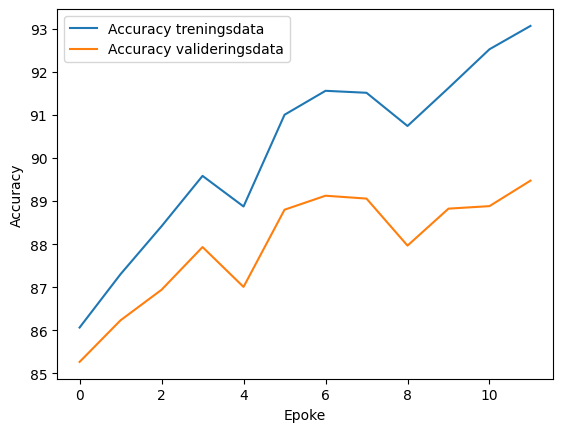

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, num_epochs), acc_train, label='Accuracy treningsdata')
plt.plot(np.arange(0, num_epochs), acc_val, label='Accuracy valideringsdata')
plt.xlabel('Epoke')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig(save_path+'accuracy.png')

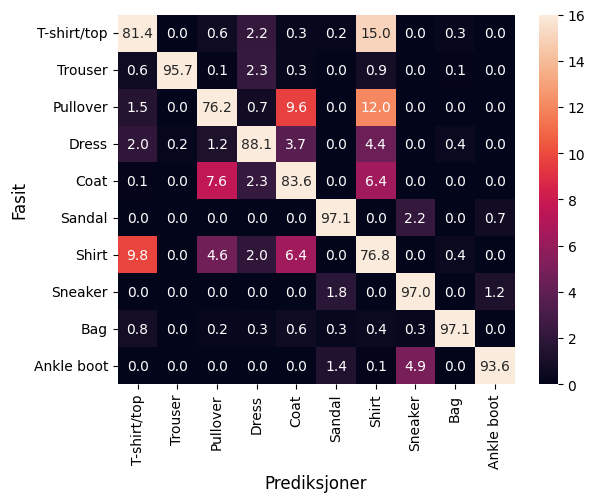

In [10]:
def make_confusion_matrix(loader, model, save_path):

    num_correct = 0
    num_samples = 0
    pred_all = np.empty(0)
    y_all = np.empty(0)
    model.eval() #setter den i evalueringsmodus

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            pred_all = np.append(pred_all, predictions)
            y_all = np.append(y_all,y)

    #fra scikit-learn: normalize{‘true’, ‘pred’, ‘all’}, default=None
    #Normalizes confusion matrix over the true (rows), predicted (columns)
    #conditions or all the population. If None, confusion matrix will not be normalized.
    cf_matrix = 100*confusion_matrix(y_all, pred_all, normalize='true')
    x_axis_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    y_axis_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    sns.heatmap(cf_matrix, annot=True,fmt=".1f",vmin=0, vmax=np.rint(np.max((cf_matrix - np.diag(np.diagonal(cf_matrix))))+1), xticklabels=x_axis_labels, yticklabels=y_axis_labels)

    plt.ylabel('Fasit',fontsize=12)
    plt.xlabel('Prediksjoner',fontsize=12)
    #plt.title('Confusion Matrix',fontsize=16)
    #plt.show()
    #plt.savefig(save_path+'confusion_matrix.png')

    model.train() #setter den tilbake i trenignsmodus


#make_confusion_matrix(val_loader, model,save_path)
#plt.savefig(save_path+'confusion_matrix_val.png')

#Til den endelige kjøringen
make_confusion_matrix(test_loader, model,save_path)
plt.savefig(save_path+'confusion_matrix_test.png')